Solving a toy diffusion problem below. We set a $u$ (exact solution), find ODE that it solves, solve the ODE, compare to exact solution
$$ Lu=\frac{d^2 u}{dx^2}$$, where we know the solution $u=sin(\pi x/2)cos(2\pi x)+1$ on interval $[0,1]$ with $x(0)=0$, $x(1)=1$ and forcing function calculated as $\frac{d^2 u}{dx^2}$. 
$$u=G(x)+D(x)*y^L$$ 
where $G(x)$ satisfies boundary conditions, $D(x)$ is smooth distance function. They ensure boundary data is fit to in a reasonable way. $y^L$ is what is approximated by the neural network to fit the ODE (or PDE depending on problem)

In [1]:
import sympy #symbolic python library
from sympy.utilities.lambdify import lambdify #translate symbolic sympy to python commands 
from sympy import init_printing
init_printing(use_latex=True) 

import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad, jacobian
from autograd.misc.optimizers import adam

from reusable_functions import init_random_params, neural_net_predict

In [2]:
#Problem Setup
x=sympy.symbols('x')
u=sympy.sin(sympy.pi/2*x)*sympy.cos(2*sympy.pi*x)+1
uprime=u.diff(x)
udprime=uprime.diff(x)
#udprime #uncomment for latex print udprime expression

forcing_fn = lambdify((x), udprime) #transform symbolic expression into python function
u=lambdify((x), u)
G=lambda x:x+1 #to satisfy BCs
D=lambda x:x*(1-x) #distance function

#Parameters
nx = 100
dx = 1. / nx
x_space = np.linspace(0, 1, nx)
batch_size=50;
layer_sizes = [1,10,10,1]
param_scale = 1
step_size=0.01;
num_iterations=1000;

params=init_random_params(param_scale, layer_sizes)

Define the loss function to compute the $y^L$ in the ansatz for the solution $u$ which was
$$u=G(x)+D(x)y^L$$ then the residual is $$Lu-f=\frac{d^2 u}{dx^2}-f$$. Simplifying and putting in the $G,D$ above gives the expression for the residual used below. 

In [3]:
dydx=grad(neural_net_predict,1)
dydx2=grad(dydx,1)
dGdx2=grad(grad(G))
dDdx=grad(D)
dDdx2=grad(grad(D))

def loss_function(params,iter):
    loss_sum = 0.
    x_batch=np.random.choice(x_space,size=batch_size) #random choice of points
    
    for i, x in enumerate(x_batch):

        input_point=x;
        y=neural_net_predict(params, x)[0]#[0] index is because of return type. 
        #gradient of neural network output w.r.t. input, evaluated at params, input_point
        dudx2=dGdx2(x)+dDdx2(x)*y+2*dDdx(x)*dydx(params,x)+D(x)*dydx2(params,x)
        resid=dudx2-forcing_fn(x)
        loss_sum=loss_sum+np.square(resid)
        
    return loss_sum/batch_size

def accuracy(params):
    loss_sum = 0.
    for i, x in enumerate(x_space):

        input_point=x;
        y=neural_net_predict(params, x)[0]#[0] index is because of return type. 
        #gradient of neural network output w.r.t. input, evaluated at params, input_point
        dudx2=dGdx2(x)+dDdx2(x)*y+2*dDdx(x)*dydx(params,x)+D(x)*dydx2(params,x)
        resid=dudx2-forcing_fn(x)
        loss_sum=loss_sum+np.square(resid)
        
    return loss_sum/np.size(x_space)


     Iteration     |    Loss fn over x_space 


/home/vassili/anaconda3/envs/thesis/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/vassili/anaconda3/envs/thesis/lib/python3.7/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


            0.0|   725.1336227495786
          100.0|  0.7616154040454675
          200.0| 0.33130176005925094
          300.0|  0.1613664365982796
          400.0| 0.09387672723107927
          500.0| 0.05491523882657319
          600.0|0.034440889163098086
          700.0| 0.02905097127175665
          800.0|0.017255288008909412
          900.0|0.017988249026108457


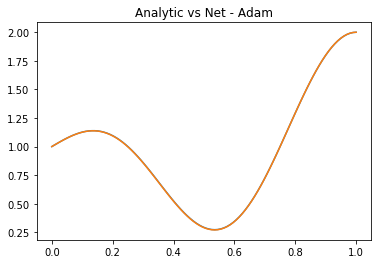

In [4]:
print("     Iteration     |    Loss fn over x_space ")
def print_perf(params, iter, gradient):
    if iter % 100 == 0:
        acc = accuracy(params)[0]
        print("{:15}|{:20}".format(iter//1., acc))
        


init_params = init_random_params(param_scale, layer_sizes)

objective_grad = grad(loss_function)

optimized_params = adam(objective_grad, init_params, step_size=step_size,
                       num_iters=num_iterations, callback=print_perf)

Text(0.5, 1.0, 'Error')

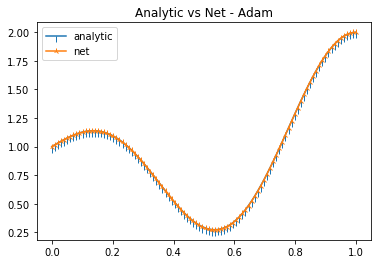

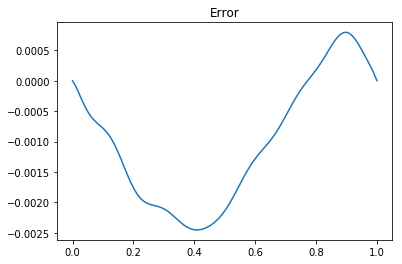

In [14]:
def plot_comparison(params, plttitle, fig_idx):
    plt.figure(fig_idx)
    plt.clf()
    ax=plt.gca()
    
    sln = np.zeros(nx)
    
    for i,x in enumerate(x_space):
        sln[i]=u(x)
        
    plt.plot(x_space, sln,label='analytic', marker=3)
    
    for i,x in enumerate(x_space):
        sln[i]=G(x)+D(x)*neural_net_predict(params, x)
        
    plt.plot(x_space, sln, label='net', marker='2')
    plt.title(plttitle)
    ax.legend()
    
plot_comparison(optimized_params, 'Analytic vs Net - Adam', 2)

err=np.zeros(np.size(x_space))
for i, x in enumerate(x_space):
    err[i]=G(x)+D(x)*neural_net_predict(optimized_params, x)-u(x)
    
plt.figure()
plt.plot(x_space, err, label='error')
plt.title('Error')
